In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

### Introduction
In the introduction, we plot just one figure related to papers publication over the years.
We read the Scopus and Web of Science data about the number of papers published with topic **Augmented Reality** and **Education**

In [2]:
with open('data/Scopus_analyze_2021_07_06.csv') as scopus_file:
    scopus_data = scopus_file.readlines()
scopus_data = scopus_data[8:-10]
scopus_data
years = []
papersScopus = []
for item in scopus_data:
    year, paper = item.split(',')
    years.append(int(''.join(filter(str.isdigit, year))))
    papersScopus.append(int(''.join(filter(str.isdigit, paper))))
years.reverse()
papersScopus.reverse()
#remove 2021 data
years.pop()
papersScopus.pop()

with open('data/WoS_analyze_2021_07_06.txt') as wos_file:
    wos_data = wos_file.readlines()
wos_data = wos_data[1:-17] # restrict to >2006 to be consistent with Scopus data
papersWos = []
for item in wos_data:
    _, paper, _ = item.split("\t")
    papersWos.append(int(''.join(filter(str.isdigit, paper))))
papersWos.reverse()

df = pd.DataFrame(list(zip(years, papersScopus, papersWos)), 
               columns =['Years', 'Scopus', 'WoS'])
df.tail(10)

,Years,Scopus,WoS
5,2011,102,54
6,2012,125,78
7,2013,185,126
8,2014,192,130
9,2015,293,234
10,2016,272,248
11,2017,454,379
12,2018,544,497
13,2019,732,664
14,2020,805,572


Now we simply create a lineplot of the numbr of papers over the years

<Figure size 1080x504 with 0 Axes>

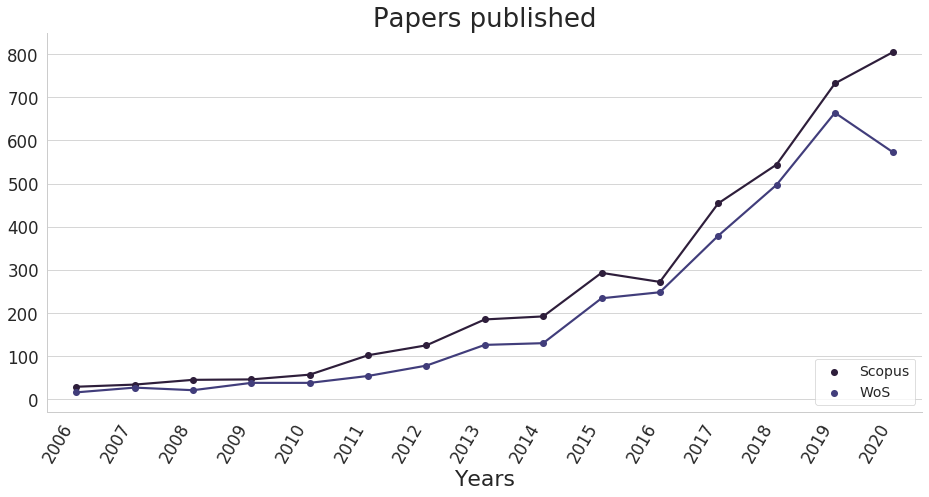

In [3]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.set_style("whitegrid")
sns.despine()
sns.set_palette(sns.color_palette("mako"))
sns.set_context("paper", rc={"axes.titlesize":8,"axes.labelsize":22})

df_melt = df.melt('Years', var_name='Index',  value_name='Papers')
df_melt.head()

g = sns.catplot(x="Years", y="Papers", hue='Index',
            kind='point', height=7, aspect=13/7,
            legend=False, data=df_melt)

plt.xticks(
    rotation=60, 
    horizontalalignment='right',
    fontweight='normal',
    fontsize='xx-large'
)

plt.yticks(
    fontweight='normal',
    fontsize='xx-large'
)

plt.title("Papers published", size=26)
#g.set(title="Papers publishes")
g.set(ylabel=None)

plt.legend(loc='lower right', prop={'size': 14})
plt.tight_layout()
plt.savefig('figures/papers_over_years.svg', dpi=300)

### Methodology

Ok, now we go to the second section, about methodology. What we want to compute in this case is the agreement between the different raters, that is Cohen's kappa, defined as

$\kappa = \frac{p_0-p_e}{1-p_e}$

where $p_0$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement.

We start first with the interrater agreement for the selction of papers reading the abstracts. 

In [4]:
papers_for_agreement = 50
accepted_R1 = 23
accepted_R2 = 24
discarded_R1 = papers_for_agreement - accepted_R1
discarded_R2 = papers_for_agreement - accepted_R2
both_accepted = 22
both_discarded = 25
only_R1_accepted = 1
only_R2_accepted = 2

p_zero = (both_accepted + both_discarded) / papers_for_agreement
p_R1_yes = accepted_R1 / papers_for_agreement
p_R1_no = discarded_R1 / papers_for_agreement
p_R2_yes = accepted_R2 / papers_for_agreement
p_R2_no = discarded_R2 / papers_for_agreement
p_e = p_R1_yes * p_R2_yes + p_R1_no * p_R2_no

kappa = (p_zero - p_e) / (1 - p_e)
kappa

0.8796147672552166

Now we do the same, but for the rater agreement after actually reading the paper. The sample size in this case is smaller, as only 10 papers were read by both researchers.

In [5]:
papers_for_agreement = 10
accepted_R1 = 2
accepted_R2 = 3
discarded_R1 = papers_for_agreement - accepted_R1
discarded_R2 = papers_for_agreement - accepted_R2
both_accepted = 2
both_discarded = 7
only_R1_accepted = 0
only_R2_accepted = 1

p_zero = (both_accepted + both_discarded) / papers_for_agreement
p_R1_yes = accepted_R1 / papers_for_agreement
p_R1_no = discarded_R1 / papers_for_agreement
p_R2_yes = accepted_R2 / papers_for_agreement
p_R2_no = discarded_R2 / papers_for_agreement

p_e = p_R1_yes * p_R2_yes + p_R1_no * p_R2_no

kappa = (p_zero - p_e) / (1 - p_e)
kappa

0.7368421052631581

### Results

Here we create the figures for section 3, reading the data from the spreadsheets containing the answers to the Google Form filled by the researchers after reading each paper

In [6]:
df2 = pd.read_excel ('data/AR in Education SLR (Responses)_all2020.xlsx', engine='openpyxl',
                     sheet_name='OnlyValid', header=0, nrows=100, usecols='B,C,E:G,I:O,V')
df2.tail()

,Which paper are you reviewing? Please copy-paste the TITLE from the GSheet.,Interesting?,Is the application interactive?,Is the application multi-user?,Is the application collaborative?,What is the subject covered by the app?,What kind of AR technology is used? (please select all that apply),Is the code of the app publicly available?,What hardware does the app support?,Which software frameworks/libraries has been used to develop the app?,Does the paper provide information regarding the number of users who tested the app?,"If you answer was Yes, could you specify how many?",When was the paper published?
95,AUGGO: Augmented Reality and Marker-based Appl...,No,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Marker-based (QR, image or 3d model based)",No,Phone,"Unity, Vuforia",Yes,14.0,2020
96,Learn chemistry with augmented reality,Yes,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Marker-based (QR, image or 3d model based), Ob...",No,Tablet,"Unity, Vuforia",Yes,270.0,2020
97,RealitySketch: Embedding Responsive Graphics a...,Yes,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Markerless (plane detection, user clicks to ad...",No,"Phone, Tablet","ARKit, A Computer vision library (OpenCV, Halc...",Yes,8.0,2020
98,Mathematics Lesson using Accelerometer Sensor ...,No,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Marker-based (QR, image or 3d model based)",No,Phone,"Unity, Vuforia",Yes,9.0,2020
99,Exploiting Extended Reality Technologies for E...,Yes,Yes,No,No,"STEM (Math, Physics, Engineering, Chemistry, I...","Marker-based (QR, image or 3d model based)",No,Phone,"Unity, Vuforia",No,NaN,2020


Before plotting anything, we just compute some numbers to include in the paper, like the number of studies presenting multiuser or collaborative app, as well as the studies published in 2018 or after.

In [7]:
publish_year_col=list(df2['When was the paper published?'])
after_2018 = publish_year_col.count(2018) + publish_year_col.count(2019) + publish_year_col.count(2020)
print(f"Published in 2018 or after = {after_2018}")

multiuser_col = df2["Is the application multi-user?"]
multiuser = multiuser_col[multiuser_col == "Yes"].count()
print(f"Apps with multiuser capabilities = {multiuser}")

collaborative_col = df2["Is the application collaborative?"]
collaborative = collaborative_col[collaborative_col == "Yes"].count()
print(f"Apps with collaborative capabilities = {collaborative}")

code_available_col = df2["Is the code of the app publicly available?"]
code_available = code_available_col[code_available_col == "Yes"].count()
print(f"Papers wich published source code of the app = {code_available}")

evaluation_info_col = df2["Does the paper provide information regarding the number of users who tested the app?"]
evaluation_info = evaluation_info_col[evaluation_info_col == "Yes"].count()
print(f"Papers providing info about the number of users who tested the app = {evaluation_info}")

Published in 2018 or after = 73
Apps with multiuser capabilities = 17
Apps with collaborative capabilities = 13
Papers wich published source code of the app = 4
Papers providing info about the number of users who tested the app = 84


As we will be using Seaborn several times to create bar plots, it make sense to define a function that we will call when creating the figures

In [8]:
def create_bar_plot(plot_data, x_label, y_label, out_image_name=None):
    sns.set(rc={'figure.figsize':(15, 7)})
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":22})

    g = sns.barplot(x=x_label, y=y_label, data=plot_data, palette="mako")

    plt.xticks( 
        fontweight='normal',
        fontsize='xx-large'
    )

    plt.yticks(
        rotation=30,
        fontweight='normal',
        fontsize='xx-large'
    )
    
    g.set(ylabel=None)
    plt.title(y_label, size=26)

    plt.tight_layout()
    if out_image_name:
        plt.savefig(out_image_name, dpi=300)

#### Subjects
We now then proceed to check the subjects covered in the studies analyzed in the review. 

In [9]:
subjects_resp =df2["What is the subject covered by the app?"].value_counts()
print(subjects_resp)

STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...)                                                           67
Humanities (First language, Art, History, Music, ...)                                                                    10
Foreign language                                                                                                          8
Physical education                                                                                                        2
STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Humanities (First language, Art, History, Music, ...)     2
Unspecified                                                                                                               2
STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Museum. Different Animals, etc.                           1
Flight simulation                                                                                                         1
3D model

There is some work to do before plotting. First of all, there is one case with both STEM and Humanities, we are going to remane this to "Multiple". Another response mixes STEM with a comment (probably an error filling the form. We will remove this entry and add the count to "STEM". Likewise, we will merge "Physical education" with "Physical education and Nutrition". Finally, we will group as "Other" all the remaining entries.


In [10]:
subjects_modified = {"STEM":0, "Humanities":0, "Foreign Language":0, "Physical Education":0,
                     "Multiple":0, "Other":0, "Unspecified":0}
subjects_dict =  dict(subjects_resp)
subjects_modified["STEM"] = subjects_dict["STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...)"] + \
          subjects_dict["STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Museum. Different Animals, etc."]
subjects_modified["Humanities"] = subjects_dict["Humanities (First language, Art, History, Music, ...)"]
subjects_modified["Foreign Language"] = subjects_dict["Foreign language"]
subjects_modified["Physical Education"] = subjects_dict["Physical education"] + \
                                          subjects_dict["Physiscal education and Nutrition"]
subjects_modified["Multiple"] = subjects_dict["STEM (Math, Physics, Engineering, Chemistry, Infromatics, ...), Humanities (First language, Art, History, Music, ...)"]
subjects_modified["Unspecified"] = subjects_dict["Unspecified"]
# Just sum together all the others
subjects_modified["Other"] = 7
subjects = pd.DataFrame.from_dict(subjects_modified, orient='index', columns=['Num. of papers'])
subjects.reset_index(inplace=True)
subjects = subjects.rename(columns={"index":"Subject"})
subjects

,Subject,Num. of papers
0,STEM,68
1,Humanities,10
2,Foreign Language,8
3,Physical Education,3
4,Multiple,2
5,Other,7
6,Unspecified,2


We are now ready to create the visualization. Again, we use Seaborn for this, and we will create an horizontal bar plot.

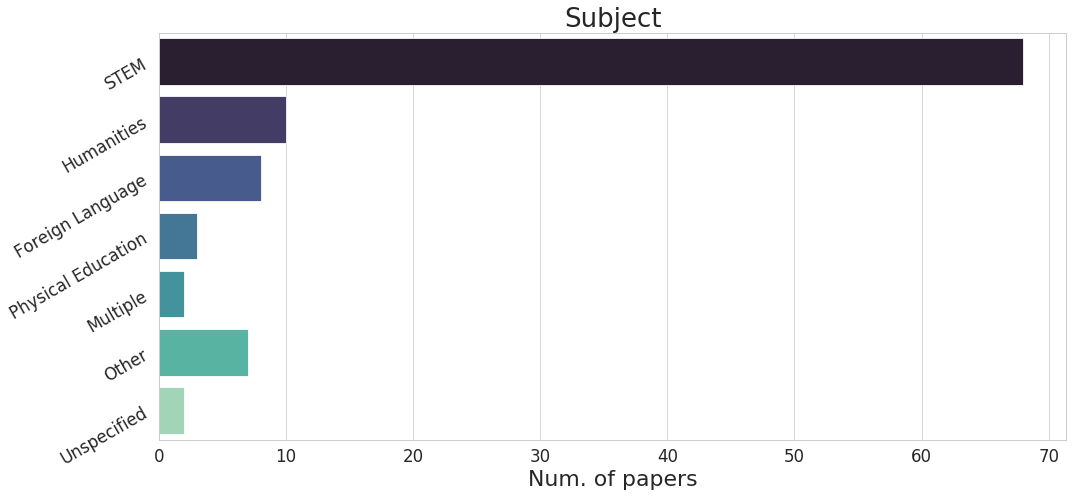

In [11]:
create_bar_plot(subjects, 'Num. of papers', 'Subject', 'figures/subjects.svg')

#### AR Technology
Now we want to do the same, but for the AR technology used

In [12]:
ar_tech_resp = df2["What kind of AR technology is used? (please select all that apply)"].value_counts()
print(ar_tech_resp)

Marker-based (QR, image or 3d model based)                                                                                                                  66
Unspecified                                                                                                                                                  9
Markerless (plane detection, user clicks to add 3d content, ...)                                                                                             9
Marker-based (QR, image or 3d model based), Location based (GPS, bluetooth, wi-fi, accelerometer, ...)                                                       4
Object recognition (Content added when specific person or object category is detected)                                                                       3
Marker-based (QR, image or 3d model based), Object recognition (Content added when specific person or object category is detected)                           2
Makey Makey boards used to command new project

And similar to what we did for the subjects, we will group the values where appropriate

In [13]:
ar_tech_modified = {"Marker based":0, "Markerless":0, "Location based":0, "Object recognition":0,
                     "Multiple":0, "Other":0, "Unspecified":0}
ar_tech_dict =  dict(ar_tech_resp)
ar_tech_modified["Marker based"] = ar_tech_dict["Marker-based (QR, image or 3d model based)"]
ar_tech_modified["Markerless"] = ar_tech_dict["Markerless (plane detection, user clicks to add 3d content, ...)"]
ar_tech_modified["Location based"] = ar_tech_dict["Location based (GPS, bluetooth, wi-fi, accelerometer, ...)"]
ar_tech_modified["Object recognition"] = ar_tech_dict["Object recognition (Content added when specific person or object category is detected)"]
ar_tech_modified["Multiple"] = ar_tech_dict["Marker-based (QR, image or 3d model based), Object recognition (Content added when specific person or object category is detected)"] + \
                               ar_tech_dict["Marker-based (QR, image or 3d model based), Markerless (plane detection, user clicks to add 3d content, ...)"] + \
                               ar_tech_dict["Marker-based (QR, image or 3d model based), Location based (GPS, bluetooth, wi-fi, accelerometer, ...)"]
ar_tech_modified["Unspecified"] = ar_tech_dict["Unspecified"]
# Just sum together all the others
ar_tech_modified["Other"] = ar_tech_dict["Makey Makey boards used to command new projections"] + \
                            ar_tech_dict["It is more an immersive solution with projectors"]
ar_tech = pd.DataFrame.from_dict(ar_tech_modified, orient='index', columns=['Num. of papers'])
ar_tech.reset_index(inplace=True)
ar_tech = ar_tech.rename(columns={"index":"AR technology"})
ar_tech

,AR technology,Num. of papers
0,Marker based,66
1,Markerless,9
2,Location based,2
3,Object recognition,3
4,Multiple,7
5,Other,3
6,Unspecified,9


We just have to create the visualization. We keep using seaborn with the same parameters

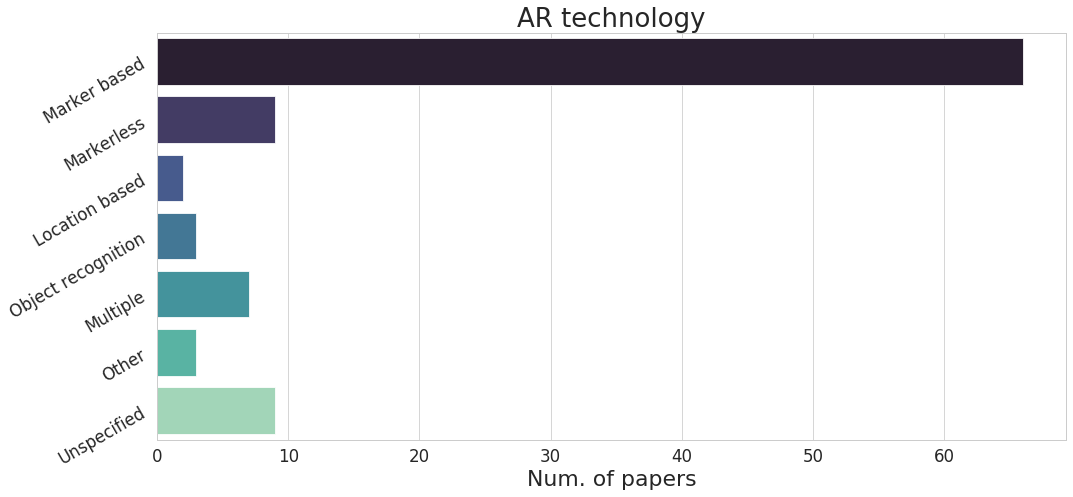

In [14]:
create_bar_plot(ar_tech, 'Num. of papers', 'AR technology', 'figures/AR_technology.svg')

#### Hardware supported
We repeat the same process, this time to creat a visualization of the hardware on which the AR applications run.

In [15]:
hardware_resp = df2["What hardware does the app support?"].value_counts()
print(hardware_resp)

Phone                                                                              38
Tablet                                                                             25
Phone, Tablet                                                                      12
Head mounted display                                                                4
Projector                                                                           3
PC + webcam                                                                         3
PC                                                                                  2
Smart glasses, Projector                                                            1
PC with Kinect camera                                                               1
Projector, Makey Makey boards                                                       1
Projector, Makey makey board                                                        1
Projector, Kinect                                     

Unlike what we did for the previous two plots, in this case (and in the next) we can have that the sum of the elements is bigger than 92, as different apps can support multiple devices (for example, an app could have been tested on both tablet and smartphones)

In [16]:
hardware_modified = {"Tablet":0, "Smartphone":0, "HMD":0, "Projector":0,
                     "PC":0, "Other":0}
hardware_dict =  dict(hardware_resp)
hardware_modified["Tablet"] = hardware_dict["Tablet"] + hardware_dict["Phone, Tablet"] + \
                              hardware_dict["Tablet, Projector"]

hardware_modified["Smartphone"] = hardware_dict["Phone"] + hardware_dict["Phone, Tablet"] + \
                             hardware_dict["Phone, Arcades"]

hardware_modified["HMD"] = hardware_dict["Head mounted display"] + \
                           hardware_dict["Smart glasses, Head mounted display, optical see-though displays; projected AR"] + \
                           hardware_dict["Smart glasses, Projector"]

# For projector and PC we manually sum. PC includes also setups with Kinect and webcam
hardware_modified["Projector"] = 3 + 1 + 1 + 1 + 1 + 1 + 1 + 1
hardware_modified["PC"] = 3 + 2 + 1 + 1 + 1 + 1
# Other includes Makey makey boards and specialized hardware (Leap motion, fish-eye cam, braille display, arcades)
hardware_modified["Other"] = 1 + 1 + 1 + 1 + 1 + 1

hardware = pd.DataFrame.from_dict(hardware_modified, orient='index', columns=['Num. of papers'])
hardware.reset_index(inplace=True)
hardware = hardware.rename(columns={"index":"Hardware supported"})
hardware

,Hardware supported,Num. of papers
0,Tablet,38
1,Smartphone,51
2,HMD,6
3,Projector,10
4,PC,9
5,Other,6


And again we call the function to create our plot

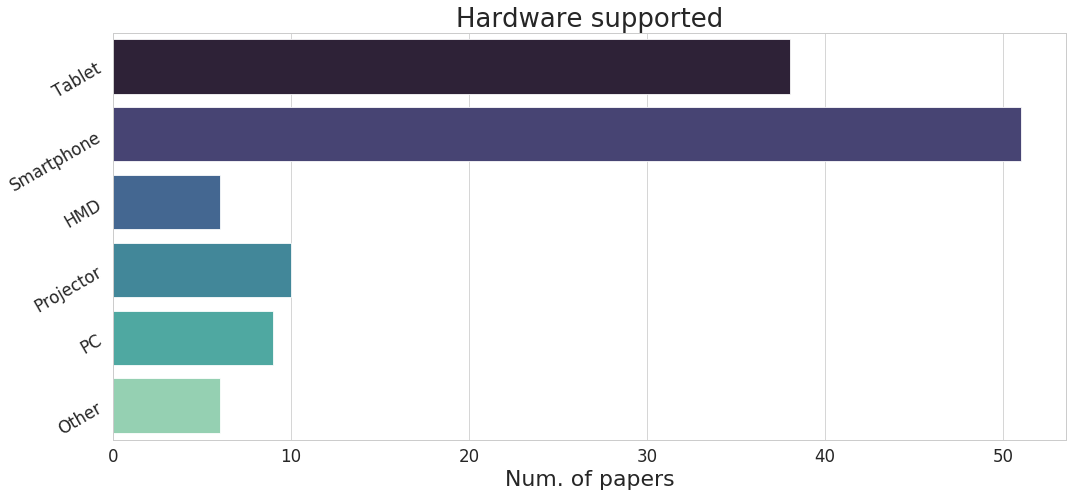

In [17]:
create_bar_plot(hardware, 'Num. of papers', 'Hardware supported', 'figures/Hardware_supported.svg')

#### Software used for development
The last bar plot we are going to create is about the sofftware used to develop the AR applications

In [18]:
software_resp = df2["Which software frameworks/libraries has been used to develop the app?"].value_counts()
print(software_resp)

Unspecified                                                                                                                                                                                                          31
Unity, Vuforia                                                                                                                                                                                                       30
Vuforia                                                                                                                                                                                                               5
Unity                                                                                                                                                                                                                 3
Unity, Vuforia, OpenGL ES                                                                                                               

Again, in this case we can have that the same app used multiple software frameworks and libraries for development, so the total is greater than the number of papers we reviewed

In [19]:
software_modified = {"Unity":0, "Vuforia":0, "ARCore":0, "ARKit":0, "CV Library":0, "DL Framework":0,
                     "MIT Scratch":0, "AR Toolkit":0, "Other":0, "Unspecified":0}
software_dict =  dict(software_resp)
software_modified["Unity"] = software_dict["Unity"] + software_dict["Unity, Vuforia"] + \
                             software_dict["Unity, Meta One SDK"] + software_dict["Unity, Vuforia, OpenGL ES"] + \
                             software_dict["Unity, ARCore"] + software_dict["Unity, ARKit"] + \
                             software_dict["Unity, IBM Watson API"] + software_dict["Unity, PUN, Placenote"] + \
                             software_dict["Unity, Microsoft Mixed Reality Toolkit"]

software_modified["Vuforia"] = software_dict["Vuforia"] + software_dict["Unity, Vuforia"] + \
                               software_dict["Unity, Vuforia, OpenGL ES"] + \
                               software_dict["Vuforia, A Computer vision library (OpenCV, Halcon, EasyCV, PCL, Dlib, ...)"]

software_modified["ARCore"] = software_dict["ARCore"] + software_dict["Unity, ARCore"] + \
                              software_dict["ARCore, A DeepLearning framework (PyTorch, Tensorflow, Caffe, Theano, ...), Cloud Vision API"]

software_modified["ARKit"] = software_dict["ARKit"] + software_dict["Unity, ARKit"]

software_modified["CV Library"] = software_dict["A Computer vision library (OpenCV, Halcon, EasyCV, PCL, Dlib, ...)"] + \
    software_dict["A Computer vision library (OpenCV, Halcon, EasyCV, PCL, Dlib, ...), ROS"] + \
    software_dict["A Computer vision library (OpenCV, Halcon, EasyCV, PCL, Dlib, ...), ARToolkit"] + \
    software_dict["Vuforia, A Computer vision library (OpenCV, Halcon, EasyCV, PCL, Dlib, ...)"] + \
    software_dict["A Computer vision library (OpenCV, Halcon, EasyCV, PCL, Dlib, ...), Java 3D"]

software_modified["DL Framework"] = 1

software_modified["MIT Scratch"] = 1 + 1
software_modified["AR Toolkit"] = 2 + 1 + 1

software_modified["Other"] = 9
software_modified["Unspecified"] = software_dict["Unspecified"]

software = pd.DataFrame.from_dict(software_modified, orient='index', columns=['Num. of papers'])
software.reset_index(inplace=True)
software = software.rename(columns={"index":"Software used"})
software

,Software used,Num. of papers
0,Unity,42
1,Vuforia,38
2,ARCore,3
3,ARKit,2
4,CV Library,6
5,DL Framework,1
6,MIT Scratch,2
7,AR Toolkit,4
8,Other,9
9,Unspecified,31


And here's the plot for the software used

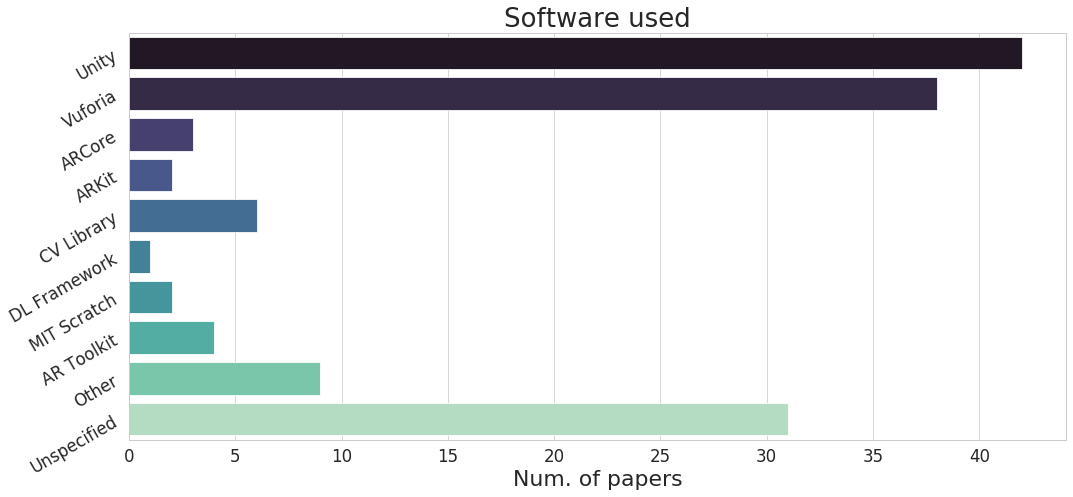

In [20]:
create_bar_plot(software, 'Num. of papers', 'Software used', 'figures/Software_used.svg')

#### Evaluation
The last plot we want to create is the histogram showing the amount of users who tested the application presented by the studies. Many studies do not provide such information, but nonetheless we show the histogram relative to the 77 studies who have this information

In [21]:
testers_resp = df2["If you answer was Yes, could you specify how many?"]

We remove all the $NaN$ entries, who refer to the papers without info about evaluation

In [22]:
testers_np = testers_resp.to_numpy()
testers = testers_np[np.isfinite(testers_np)]
len(testers) # Should be 84

84

In [23]:
df3 = pd.DataFrame({'Testers': testers})

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


<Figure size 1080x504 with 0 Axes>

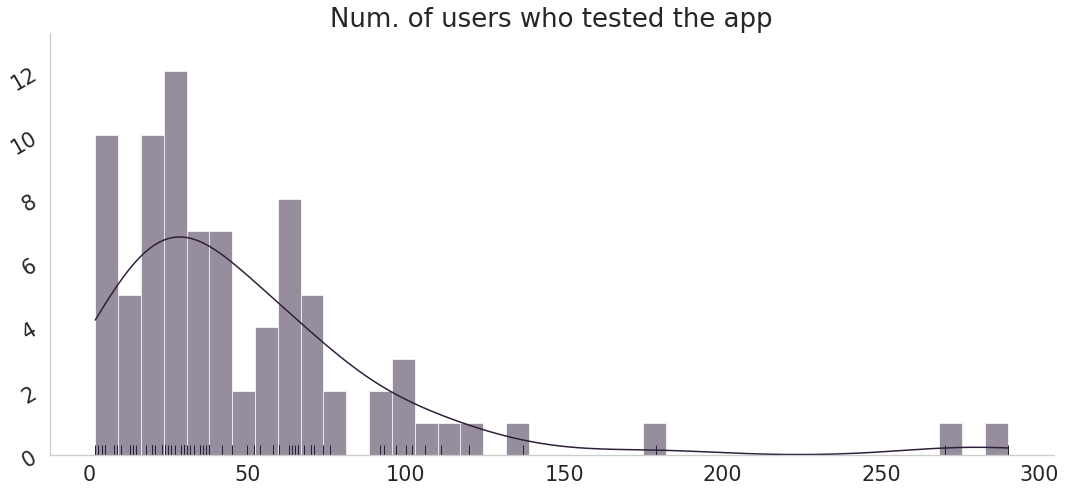

In [24]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.despine()
sns.set_palette(sns.color_palette("mako"))

g = sns.displot(df3, x="Testers", kind="hist", kde=True, rug=True, bins=40)

plt.xticks( 
    fontweight='normal',
    fontsize='xx-large'
)

plt.yticks(
    rotation=30,
    fontweight='normal',
    fontsize='xx-large'
)

g.set(ylabel=None)
g.set(xlabel=None)
plt.title("Num. of users who tested the app", size=26)

fig = plt.gcf()
fig.set_size_inches( 15, 7)

plt.tight_layout()
plt.savefig('figures/hist_testers.svg', dpi=300)